# Decision-Focused Learning 

### Library import

In [23]:
import os, random, numpy as np, pandas as pd, torch, cvxpy as cp, matplotlib.pyplot as plt
from tqdm import tqdm
import sys, subprocess
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
import cvxpy as cp
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
def _pip_install(pkg): 
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

try:
    import yfinance
except ImportError:
    _pip_install("yfinance")

### Load and prepare financial data  
Download stock price data from Yahoo Finance and compute returns, mean vector (μ), and covariance matrix (Σ).

In [6]:
def get_portfolio_data(tickers, start="2018-01-01", end="2023-12-31", freq="1d", visualize=True):
    print(f"Downloading {len(tickers)} assets from {start} to {end} ...")
    data = yf.download(
        tickers,
        start=start,
        end=end,
        interval=freq,
        group_by="column",
        auto_adjust=True,
        progress=False,
        threads=True,
    )

    if data.empty:
        raise RuntimeError("Downloaded data is empty. Check tickers, dates or internet connection.")

    if isinstance(data.columns, pd.MultiIndex):
        lvl0 = data.columns.get_level_values(0)
        if "Close" in lvl0:
            prices = data.xs("Close", axis=1, level=0)
        elif "Adj Close" in lvl0:
            prices = data.xs("Adj Close", axis=1, level=0)
        else:
            raise KeyError(f"Expected 'Close' or 'Adj Close' in columns level-0. Found: {sorted(set(lvl0))}")
    else:
        cols = data.columns
        if "Close" in cols:
            prices = data["Close"].to_frame() if not isinstance(tickers, (list, tuple)) else data["Close"]
        elif "Adj Close" in cols:
            prices = data["Adj Close"].to_frame() if not isinstance(tickers, (list, tuple)) else data["Adj Close"]
        else:
            raise KeyError(f"Expected 'Close' or 'Adj Close' in columns. Found: {list(cols)}")

    prices = prices.dropna(axis=0, how="any")
    if prices.empty:
        raise RuntimeError("Prices are empty after dropna(). Try a wider date range or different tickers.")

    returns = np.log(prices / prices.shift(1)).dropna()
    mu = returns.mean().values
    Sigma = returns.cov().values

    prices.to_csv("data/raw/prices.csv")
    returns.to_csv("data/processed/returns.csv")
    pd.DataFrame(mu, index=returns.columns, columns=["mu"]).to_csv("data/processed/mu.csv")
    pd.DataFrame(Sigma, index=returns.columns, columns=returns.columns).to_csv("data/processed/Sigma.csv")

    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        prices.plot(ax=axes[0], legend=False)
        axes[0].set_title("Adjusted Close (auto_adjust=True)"); axes[0].set_xlabel("Date"); axes[0].set_ylabel("Price")
        corr = returns.corr()
        im = axes[1].imshow(corr, vmin=-1, vmax=1)
        axes[1].set_xticks(range(len(corr.columns))); axes[1].set_xticklabels(corr.columns, rotation=45, ha="right")
        axes[1].set_yticks(range(len(corr.index)));  axes[1].set_yticklabels(corr.index)
        axes[1].set_title("Return Correlation Heatmap")
        fig.colorbar(im, ax=axes[1])
        plt.tight_layout(); plt.show()

    return prices, returns, mu, Sigma

### Run data fetching  
Select a list of assets and retrieve prices, returns, and covariance matrix.

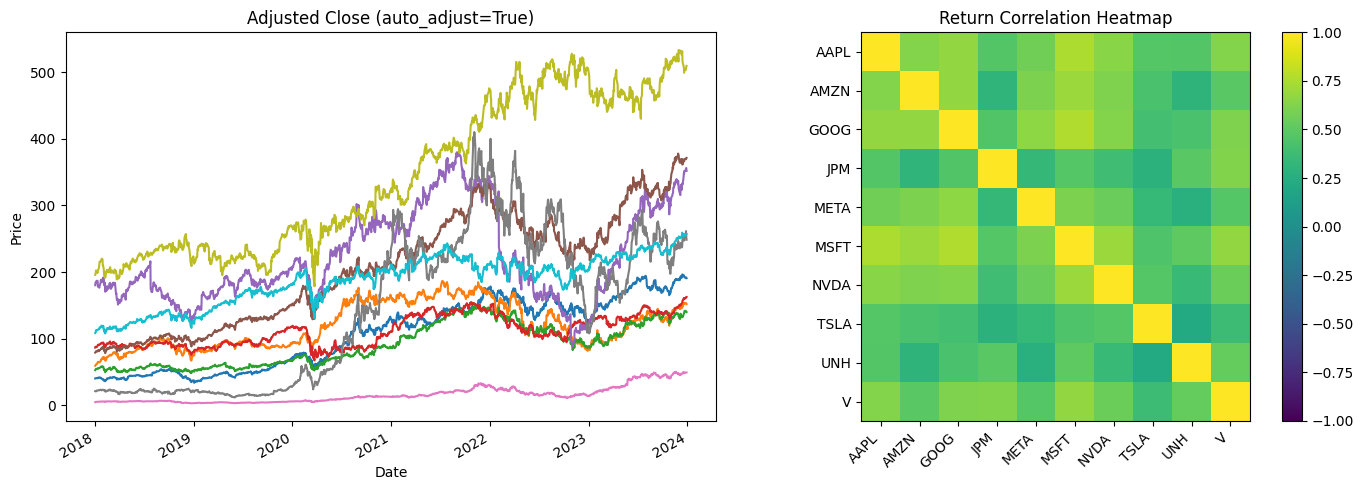


μ (mean returns) first 5: [0.00103 0.00062 0.00065 0.00042 0.00044]
Σ shape: (10, 10)


In [7]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "META", "NVDA", "JPM", "TSLA", "UNH", "V"]

prices, returns, mu, Sigma = get_portfolio_data(
    tickers=tickers,
    start="2018-01-01",
    end="2023-12-31",
    freq="1d",
    visualize=True
)

print("\nμ (mean returns) first 5:", np.round(mu[:5], 5))
print("Σ shape:", Sigma.shape)

### Build supervised dataset (lags) and temporal split  
Transform the return matrix into a supervised learning dataset:  
features = last L days of returns for each asset;  
target = next-day return vector for all assets.  
We perform a chronological split: train (2018–2021), validation (2022), test (2023).

In [13]:
def build_supervised_from_returns(R: pd.DataFrame, lags: int = 5):
    R = R.copy()
    X_list, Y_list, dates = [], [], []

    for t in range(lags, len(R) - 1):
        X_t = R.iloc[t - lags:t].values.flatten()  
        Y_t = R.iloc[t + 1].values                 
        X_list.append(X_t)
        Y_list.append(Y_t)
        dates.append(R.index[t + 1])               

    X = np.array(X_list)
    Y = np.array(Y_list)
    dates = pd.to_datetime(dates)
    feature_names = [f"{col}_lag{l}" for l in range(lags, 0, -1) for col in R.columns]
    return X, Y, dates, feature_names


LAGS = 5
X_all, Y_all, dates_all, feat_names = build_supervised_from_returns(returns, lags=LAGS)

print("Supervised dataset shapes:")
print("  X_all:", X_all.shape)
print("  Y_all:", Y_all.shape)
print("  Date range:", dates_all.min(), "→", dates_all.max())

split_train, split_val, split_test = "2022-01-01", "2023-01-01", "2023-12-01"

train_mask = dates_all < split_train
val_mask   = (dates_all >= split_train) & (dates_all < split_val)
test_mask  = dates_all >= split_val

print("\nDate coverage:")
print("Train:", dates_all[train_mask].min(), "→", dates_all[train_mask].max())
print("Val:  ", dates_all[val_mask].min(), "→", dates_all[val_mask].max())
print("Test: ", dates_all[test_mask].min(), "→", dates_all[test_mask].max())

X_train, Y_train = X_all[train_mask], Y_all[train_mask]
X_val,   Y_val   = X_all[val_mask],   Y_all[val_mask]
X_test,  Y_test  = X_all[test_mask],  Y_all[test_mask]

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("\nShapes:")
print("  X_train, Y_train:", X_train_s.shape, Y_train.shape)
print("  X_val,   Y_val:  ", X_val_s.shape,   Y_val.shape)
print("  X_test,  Y_test: ", X_test_s.shape,  Y_test.shape)
print("Assets (N):", Y_train.shape[1], " | Lags:", LAGS, " | Features:", X_train_s.shape[1])

Supervised dataset shapes:
  X_all: (1502, 50)
  Y_all: (1502, 10)
  Date range: 2018-01-11 00:00:00 → 2023-12-29 00:00:00

Date coverage:
Train: 2018-01-11 00:00:00 → 2021-12-31 00:00:00
Val:   2022-01-03 00:00:00 → 2022-12-30 00:00:00
Test:  2023-01-03 00:00:00 → 2023-12-29 00:00:00

Shapes:
  X_train, Y_train: (1001, 50) (1001, 10)
  X_val,   Y_val:   (251, 50) (251, 10)
  X_test,  Y_test:  (250, 50) (250, 10)
Assets (N): 10  | Lags: 5  | Features: 50


# PtO

### Train multi-output predictor (μ̂) on lags
We fit a ridge multi-output model on standardized lag features to predict next-day returns for all assets.

In [15]:
alphas = np.logspace(-4, 4, 21)
ridge = RidgeCV(alphas=alphas, fit_intercept=True, cv=None)
ridge.fit(X_train_s, Y_train)

Y_val_pred = ridge.predict(X_val_s)
Y_test_pred = ridge.predict(X_test_s)

print("Ridge fitted. Val/Test shapes:", Y_val_pred.shape, Y_test_pred.shape)

Ridge fitted. Val/Test shapes: (251, 10) (250, 10)


### Quadratic program for portfolio choice 
Minimize  (1/2) xᵀ Σ x − (1/λ) μᵀ x  subject to  1ᵀx=1, x≥0.
We ensure Σ is PSD by adding εI if needed.

In [18]:
def project_psd(S, eps=1e-8):
    w, V = np.linalg.eigh((S + S.T) / 2)
    w_clipped = np.clip(w, eps, None)
    return V @ np.diag(w_clipped) @ V.T

def solve_markowitz(mu_vec, Sigma_mat, lam=10.0, long_only=True):
    N = len(mu_vec)
    x = cp.Variable(N)
    Sigma_psd = project_psd(Sigma_mat, eps=1e-8)
    obj = 0.5 * cp.quad_form(x, Sigma_psd) - (1.0 / lam) * mu_vec @ x
    cons = [cp.sum(x) == 1]
    if long_only:
        cons.append(x >= 0)
    prob = cp.Problem(cp.Minimize(obj), cons)
    prob.solve(solver=cp.OSQP, eps_abs=1e-8, eps_rel=1e-8, verbose=False)
    return np.asarray(x.value).ravel()

### Validation: select λ by minimizing average validation regret
For each date τ in validation, compute x(μ̂_τ; λ) and the *decision loss* under true μ_τ:
L(μ̂_τ, μ_τ; λ) = f(x(μ̂_τ), μ_τ) − f(x*(μ_τ), μ_τ), where f(x, μ)=½ xᵀΣx − (1/λ) μᵀx.
We average regret across τ and pick λ* with minimal regret.

In [20]:
dates_train = dates_all[dates_all < "2022-01-01"]
Sigma_train = returns.loc[returns.index.isin(dates_train)].cov().values

def decision_objective(x, mu_vec, Sigma_mat, lam):
    return 0.5 * x @ Sigma_mat @ x - (1.0 / lam) * (mu_vec @ x)

def average_regret(mu_pred_seq, mu_true_seq, Sigma_mat, lam):
    regrets = []
    for mu_hat, mu_true in zip(mu_pred_seq, mu_true_seq):
        x_hat = solve_markowitz(mu_hat, Sigma_mat, lam=lam, long_only=True)
        x_star = solve_markowitz(mu_true, Sigma_mat, lam=lam, long_only=True)
        loss_hat = decision_objective(x_hat, mu_true, Sigma_mat, lam)
        loss_star = decision_objective(x_star, mu_true, Sigma_mat, lam)
        regrets.append(loss_hat - loss_star)
    return float(np.mean(regrets)), np.array(regrets)

lambda_grid = np.logspace(-2, 2, 15)
val_regrets = []
for lam in lambda_grid:
    avg_reg, _ = average_regret(Y_val_pred, Y_val, Sigma_train, lam)
    val_regrets.append(avg_reg)

lam_star = float(lambda_grid[int(np.argmin(val_regrets))])
print("Chosen λ* (min avg regret on validation):", lam_star)

Chosen λ* (min avg regret on validation): 100.0


### Test evaluation: regret, realized cumulative return, Sharpe
We evaluate decision quality on test dates using λ*.  
We also compute realized daily returns of the chosen portfolio: r_t = x_t(μ̂_t)ᵀ · μ_true_t, and summarize with cumulative return and Sharpe.

In [21]:
avg_reg_test, regrets_test = average_regret(Y_test_pred, Y_test, Sigma_train, lam_star)

def realized_path(mu_pred_seq, mu_true_seq, Sigma_mat, lam):
    rets = []
    xs = []
    for mu_hat, mu_true in zip(mu_pred_seq, mu_true_seq):
        x_hat = solve_markowitz(mu_hat, Sigma_mat, lam=lam, long_only=True)
        xs.append(x_hat)
        rets.append(float(x_hat @ mu_true))
    return np.array(rets), np.array(xs)

test_realized, test_weights = realized_path(Y_test_pred, Y_test, Sigma_train, lam_star)
cum_ret = np.cumprod(1.0 + test_realized) - 1.0
sharpe = np.mean(test_realized) / (np.std(test_realized) + 1e-12) * np.sqrt(252)

print("Test avg regret:", np.round(avg_reg_test, 6))
print("Test realized mean daily return:", np.round(test_realized.mean(), 6))
print("Test Sharpe (annualized):", np.round(sharpe, 3))
print("Final cumulative return:", np.round(cum_ret[-1], 3))



Test avg regret: 0.000153
Test realized mean daily return: 0.00136
Test Sharpe (annualized): 2.171
Final cumulative return: 0.387



### Baselines for context: clairvoyant and equal-weight

In [22]:
def clairvoyant_realized(mu_true_seq, Sigma_mat, lam):
    rets = []
    for mu_true in mu_true_seq:
        x_star = solve_markowitz(mu_true, Sigma_mat, lam=lam, long_only=True)
        rets.append(float(x_star @ mu_true))
    rets = np.array(rets)
    return rets, np.cumprod(1.0 + rets) - 1.0

def equal_weight_realized(mu_true_seq, N):
    x_eq = np.ones(N) / N
    rets = np.array([float(x_eq @ mu_t) for mu_t in mu_true_seq])
    return rets, np.cumprod(1.0 + rets) - 1.0

cw_rets, cw_cum = clairvoyant_realized(Y_test, Sigma_train, lam_star)
eq_rets, eq_cum = equal_weight_realized(Y_test, Y_test.shape[1])

cw_sharpe = cw_rets.mean() / (cw_rets.std() + 1e-12) * np.sqrt(252)
eq_sharpe = eq_rets.mean() / (eq_rets.std() + 1e-12) * np.sqrt(252)

print("Clairvoyant Sharpe (annualized):", np.round(cw_sharpe, 3), " | Final cum:", np.round(cw_cum[-1], 3))
print("Equal-weight Sharpe (annualized):", np.round(eq_sharpe, 3), " | Final cum:", np.round(eq_cum[-1], 3))

Clairvoyant Sharpe (annualized): 13.462  | Final cum: 255.359
Equal-weight Sharpe (annualized): 2.77  | Final cum: 0.686


### Cumulative returns and regret distribution
Cumulative performance vs baselines and the distribution of test regrets.

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(cum_ret, label="PtO (Ridge + Markowitz)")
plt.plot(cw_cum, label="Clairvoyant (oracle)")
plt.plot(eq_cum, label="Equal-weight")
plt.title("Cumulative Return (Test)")
plt.xlabel("Days"); plt.ylabel("Cumulative Return")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(regrets_test, bins=30, density=True)
plt.title("Decision Regret Distribution (Test)")
plt.xlabel("Regret"); plt.ylabel("Density")
plt.tight_layout(); plt.show()

### Robustness: decision quality under prediction noise




In [27]:
mu_test_pred = Y_test_pred          
R_test = Y_test                     
risk_aversion = lam_star         

print("mu_test_pred shape:", mu_test_pred.shape)
print("R_test shape:", R_test.shape)
print("risk_aversion:", risk_aversion)

def evaluate_sequence(mu_seq, R_seq, Sigma, risk_aversion):
    T, N = mu_seq.shape
    w_seq = np.zeros((T, N))
    for t in range(T):
        w_seq[t] = solve_markowitz(mu_seq[t], Sigma, risk_aversion, long_only=True)
    port_rets = np.sum(w_seq * R_seq, axis=1)
    cum = np.cumprod(1.0 + port_rets) - 1.0
    sharpe = np.sqrt(252.0) * np.mean(port_rets) / (np.std(port_rets) + 1e-12)
    return {
        "w_seq": w_seq,
        "port_rets": port_rets,
        "cum_final": float(cum[-1]),
        "sharpe": float(sharpe),
        "avg_ret": float(np.mean(port_rets))
    }

def compute_avg_regret(mu_seq, R_seq, Sigma, risk_aversion):
    T, N = mu_seq.shape
    regret = []
    for t in range(T):
        w_hat = solve_markowitz(mu_seq[t], Sigma, risk_aversion, long_only=True)
        w_star = solve_markowitz(R_seq[t], Sigma, risk_aversion, long_only=True)
        u_hat = float(R_seq[t] @ w_hat - 0.5 * risk_aversion * w_hat @ Sigma @ w_hat)
        u_star = float(R_seq[t] @ w_star - 0.5 * risk_aversion * w_star @ Sigma @ w_star)
        regret.append(u_star - u_hat)
    return float(np.mean(regret))

import time
sig_base = float(np.std(mu_test_pred))
noise_levels = [0.0, 0.1*sig_base, 0.25*sig_base, 0.5*sig_base, 0.75*sig_base, 1.0*sig_base]

rows = []
for sig in noise_levels:
    rng = np.random.default_rng(42)
    mu_noisy = mu_test_pred + sig * rng.standard_normal(mu_test_pred.shape)
    t0 = time.time()
    metrics = evaluate_sequence(mu_noisy, R_test, Sigma, risk_aversion)
    avg_reg = compute_avg_regret(mu_noisy, R_test, Sigma, risk_aversion)
    dt = time.time() - t0
    rows.append({
        "noise_sigma": sig,
        "test_avg_regret": avg_reg,
        "test_sharpe": metrics["sharpe"],
        "final_cum_return": metrics["cum_final"],
        "eval_time_sec": dt
    })

robust_df = pd.DataFrame(rows)
display(robust_df)

mu_test_pred shape: (250, 10)
R_test shape: (250, 10)
risk_aversion: 100.0


,noise_sigma,test_avg_regret,test_sharpe,final_cum_return,eval_time_sec
0,0.000000,0.014316,1.922255,0.275564,3.564044
1,0.000113,0.014329,1.893672,0.271850,3.040955
2,0.000282,0.014356,1.859539,0.267785,3.048664
3,0.000564,0.014422,1.802673,0.261528,3.018453
4,0.000846,0.014500,1.757429,0.258175,3.013375
5,0.001127,0.014593,1.715132,0.255852,3.017676


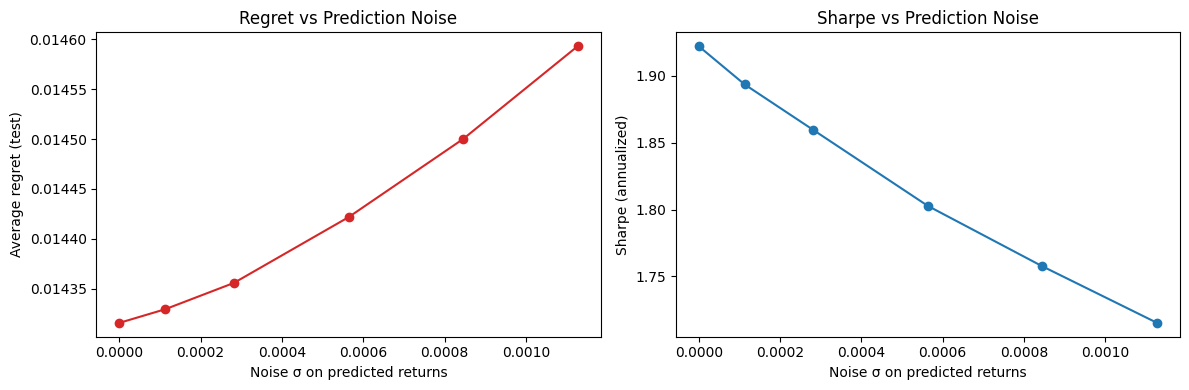

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(robust_df["noise_sigma"], robust_df["test_avg_regret"], marker="o", color="tab:red")
ax[0].set_xlabel("Noise σ on predicted returns")
ax[0].set_ylabel("Average regret (test)")
ax[0].set_title("Regret vs Prediction Noise")

ax[1].plot(robust_df["noise_sigma"], robust_df["test_sharpe"], marker="o", color="tab:blue")
ax[1].set_xlabel("Noise σ on predicted returns")
ax[1].set_ylabel("Sharpe (annualized)")
ax[1].set_title("Sharpe vs Prediction Noise")

plt.tight_layout()
plt.show()

### Computational Efficiency and Solver Integration

Avg solve time (N=10): 5.55 ms ± 8.64 ms


,N_assets,avg_time_sec
0,5,0.005922
1,10,0.006402
2,20,0.004258
3,30,0.004406
4,40,0.004290


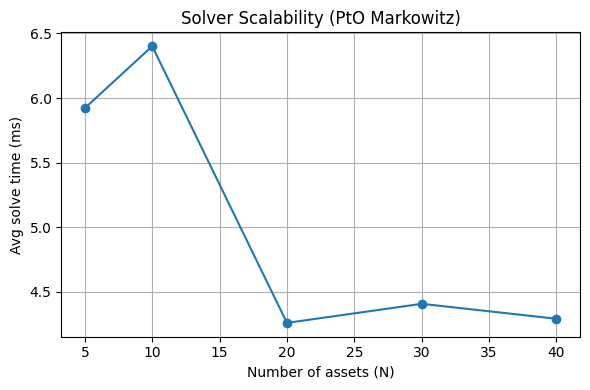

In [29]:
def benchmark_solver(mu_seq, Sigma, lam, solver="OSQP"):
    times = []
    for mu in mu_seq:
        start = time.time()
        _ = solve_markowitz(mu, Sigma, lam, long_only=True)
        times.append(time.time() - start)
    return np.mean(times), np.std(times)

mean_t, std_t = benchmark_solver(Y_test_pred[:50], Sigma_train, lam_star)
print(f"Avg solve time (N=10): {mean_t*1000:.2f} ms ± {std_t*1000:.2f} ms")

scalability = []
for n_assets in [5, 10, 20, 30, 40]:
    idx = np.arange(min(n_assets, Y_test_pred.shape[1]))
    Sigma_sub = Sigma_train[np.ix_(idx, idx)]
    mu_sub_seq = [mu[idx] for mu in Y_test_pred[:20]]  # first 20 test periods
    mean_t, _ = benchmark_solver(mu_sub_seq, Sigma_sub, lam_star)
    scalability.append((n_assets, mean_t))

scal_df = pd.DataFrame(scalability, columns=["N_assets", "avg_time_sec"])
display(scal_df)

plt.figure(figsize=(6,4))
plt.plot(scal_df["N_assets"], scal_df["avg_time_sec"]*1000, marker="o")
plt.title("Solver Scalability (PtO Markowitz)")
plt.xlabel("Number of assets (N)")
plt.ylabel("Avg solve time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()